In [ ]:
!pip install PySastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd ./drive/MyDrive/Akademik/NLP/

/content/drive/MyDrive/Akademik/NLP


In [ ]:
!ls

cleaned_test.pickle  cleaned_train.pickle  data_worthcheck  data_worthcheck.zip


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
import seaborn as sns
import nltk
from sklearn import metrics
from sklearn.svm import SVC
import time
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Import Data

In [ ]:
df = pd.read_csv("./data_worthcheck/train.csv",index_col=0)
df

,text_a,label
0,betewe buka twitter cuman ngetweet liat home b...,no
1,mas piyuuu mugo2 corona tuh mulut tersumpal ma...,no
2,e100ss gini buka informasi sejelas nya identit...,yes
3,neng solo wes ono terduga corona cobo neng ati...,no
4,midiahn nii akun gak takut takut nya isu coron...,no
...,...,...
21596,depok panas ga karuan kereta sampe pasming huj...,no
21597,oxfara arie kriting yg lebi goblo nya orang ke...,no
21598,virus corona menyaba depok cuci tangan makan n...,no
21599,mata sipit tinggal depok udah abis dah bahan c...,no


In [ ]:
test_df = pd.read_csv("./data_worthcheck/test.csv")
test_df

,text_a,label
0,jek dajal ga depok bang,no
1,detikcom untung depok masuk wilayah nya ridwan...,no
2,df dom jakarta depok yg gunain vc cabang nya c...,no
3,your2rl depok jkt,no
4,doakan indonesia selamat virus corona pkb depo...,yes
...,...,...
2795,ku tenang2 bae ku sih ya corona nya ga depok k...,no
2796,guru hati hati ya virus corona uda indonesia t...,yes
2797,4 terawan menyebut virus corona indonesia terd...,yes
2798,realffk buhari can t pronounce corona virus,no


In [ ]:
text_normalization_url = "https://raw.githubusercontent.com/okkyibrohim/id-multi-label-hate-speech-and-abusive-language-detection/master/new_kamusalay.csv"
text_normalization_df = pd.read_csv(text_normalization_url,names=['slang', 'normal'], encoding='ISO-8859-1')
text_normalization_df

,slang,normal
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


## Analyse Data

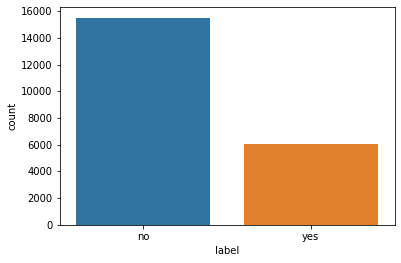

In [ ]:

ax = sns.countplot(x="label", data=df)

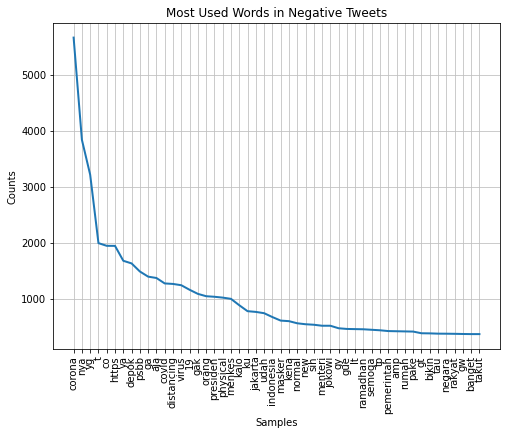

In [ ]:

negativeFD = nltk.FreqDist(word for text in df[df["label"] == "no"]["text_a"] for word in text.lower().split())
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Negative Tweets")
negativeFD.plot(50)
plt.show()

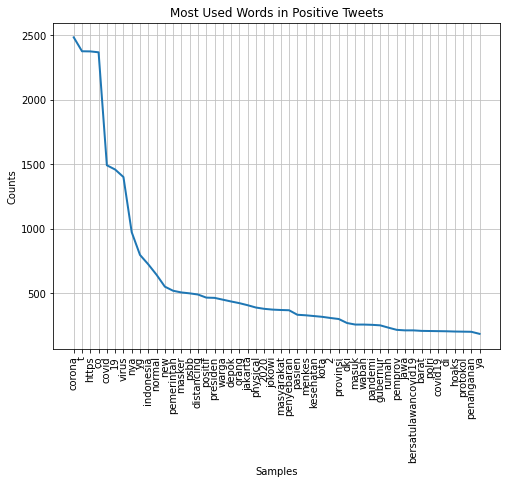

In [ ]:
positiveFD = nltk.FreqDist(word for text in df[df["label"] == "yes"]["text_a"] for word in text.lower().split())
plt.subplots(figsize=(8,6))
plt.title("Most Used Words in Positive Tweets")
positiveFD.plot(50)
plt.show()

## Preprocess Data

In [ ]:
df.loc[df["label"] == "no",'label']= 0
df.loc[df["label"] == "yes",'label'] = 1
test_df.loc[test_df["label"] == "no",'label']= 0
test_df.loc[test_df["label"] == "yes",'label'] = 1


In [ ]:

def preprocess_x(df, normaliseText = True):
  cleanedData = []

  factory = StemmerFactory()
  bahasa_stemmer = factory.create_stemmer()
  factory = StopWordRemoverFactory()
  stopwords = factory.get_stop_words()
  swords = stopwords
  for text in df["text_a"]:
      
      text = text.lower()

      # Cleaning links
      text = re.sub(r'https\s+t\s+co\s\w+', '', text)
      
      # Cleaning everything except alphabetical characters
      text = re.sub("[^a-zA-Z]"," ",text)
      
      
      # Tokenizing and lemmatizing
      text = nltk.word_tokenize(text)

      # Normalize text
      if normaliseText:
        normalized_text = []
        for word in text:
          if (text_normalization_df['slang'] == word).any():
            index =  text_normalization_df.index[text_normalization_df['slang'] == word]
            normalized_text.append(text_normalization_df.iloc[index[0]]['normal'])
          else:
            normalized_text.append(word)
      else:
        normalized_text = text

      # Stem Text
      text = [bahasa_stemmer.stem(word) for word in normalized_text]
      
      # Removing stopwords
      text = [word for word in text if word not in swords]
      
      # Joining
      text = " ".join(text)
      
      cleanedData.append(text)
  return cleanedData

In [ ]:
preprocessed_x_train = preprocess_x(df)
preprocessed_x_test = preprocess_x(test_df)

In [ ]:
preprocessed_x_train_without_normalization = preprocess_x(df,False)
preprocessed_x_test_without_normalization = preprocess_x(test_df,False)

In [ ]:
for i in range(0,5):
    print(df.iloc[i]["text_a"])
    print(preprocessed_x_train[i],end="\n\n")
    


betewe buka twitter cuman ngetweet liat home berita corona panik kepikiran ndamau buka2 home yg aware aja i ll stay at home nda rumah kalo nda penting2 banget
betewe buka twitter mentwit home berita corona panik pikir ndamau buka home aware ll stay at home rumah banget

mas piyuuu mugo2 corona tuh mulut tersumpal ma corona
mas piyuuu mugo corona mulut sumpal corona

e100ss gini buka informasi sejelas nya identitas daerah penderita terjangkit infokan masyarakat mengisolasi nya kontak langsung penderita positif corona ditutup tutupi
screenshoot buka informasi identitas daerah derita jangkit info masyarakat isolasi kontak derita positif corona tutup tutup

neng solo wes ono terduga corona cobo neng ati mu neng conora
neng solo ono duga corona cobo neng hati mu neng conora

midiahn nii akun gak takut takut nya isu corona wkwkwkw
midiahn akun takut takut isu corona wkwk



In [ ]:

normalized_count_vectorizer = CountVectorizer()
normalized_tfidf_vectorizer = TfidfVectorizer()

unnormalized_count_vectorizer = CountVectorizer()
unnormalized_tfidf_vectorizer = TfidfVectorizer()


In [ ]:
normalized_count_x_train = normalized_count_vectorizer.fit_transform(preprocessed_x_train)
normalized_count_x_test = normalized_count_vectorizer.transform(preprocessed_x_test)

normalized_tfidf_x_train = normalized_tfidf_vectorizer.fit_transform(preprocessed_x_train)
normalized_tfidf_x_test = normalized_tfidf_vectorizer.transform(preprocessed_x_test)

unnormalized_count_x_train = unnormalized_count_vectorizer.fit_transform(preprocessed_x_train_without_normalization)
unnormalized_count_x_test = unnormalized_count_vectorizer.transform(preprocessed_x_test_without_normalization)

unnormalized_tfidf_x_train = unnormalized_tfidf_vectorizer.fit_transform(preprocessed_x_train_without_normalization)
unnormalized_tfidf_x_test = unnormalized_tfidf_vectorizer.transform(preprocessed_x_test_without_normalization)

y_train = np.asarray(df["label"]).astype('int')
y_test = np.asarray(test_df["label"]).astype('int')


## Train Model

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [ ]:
# Model Definition
normalized_count_model = SVC(random_state=42)
unnormalized_count_model = SVC(random_state=42)
normalized_tfidf_model = SVC(random_state=42)
unnormalized_tfidf_model = SVC(random_state=42)

In [ ]:

start_time = time.time()

normalized_count_model.fit(normalized_count_x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting normalized_count_model SVC took {} seconds".format(process_time))

Fitting normalized_count_model SVC took 141.62 seconds


In [ ]:
start_time = time.time()

normalized_tfidf_model.fit(normalized_tfidf_x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting normalized_tfidf_model SVC took {} seconds".format(process_time))

Fitting normalized_tfidf_model SVC took 131.14 seconds


In [ ]:
start_time = time.time()

unnormalized_count_model.fit(unnormalized_count_x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took unnormalized_count_model {} seconds".format(process_time))

Fitting SVC took unnormalized_count_model 128.98 seconds


In [ ]:
start_time = time.time()

unnormalized_tfidf_model.fit(unnormalized_tfidf_x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting unnormalized_tfidf_model SVC took {} seconds".format(process_time))

Fitting unnormalized_tfidf_model SVC took 165.55 seconds


## Prediction Result

In [ ]:
normalized_count_predictions = normalized_count_model.predict(normalized_count_x_test)
print("Accuracy of normalized_count model is {}%".format(accuracy_score(y_test,normalized_count_predictions) * 100))

Accuracy of normalized_count model is 85.39285714285715%


In [ ]:
normalized_tfidf_predictions = normalized_tfidf_model.predict(normalized_tfidf_x_test)
print("Accuracy of normalized_tfidf model is {}%".format(accuracy_score(y_test,normalized_tfidf_predictions) * 100))

Accuracy of normalized_tfidf model is 86.25%


In [ ]:
unnormalized_count_predictions = unnormalized_count_model.predict(unnormalized_count_x_test)
print("Accuracy of unnormalized_count model is {}%".format(accuracy_score(y_test,unnormalized_count_predictions) * 100))

Accuracy of unnormalized_count model is 85.75%


In [ ]:
unnormalized_tfidf_predictions = unnormalized_tfidf_model.predict(unnormalized_tfidf_x_test)
print("Accuracy of unnormalized_tfidf model is {}%".format(accuracy_score(y_test,unnormalized_tfidf_predictions) * 100))

Accuracy of unnormalized_tfidf model is 87.14285714285714%


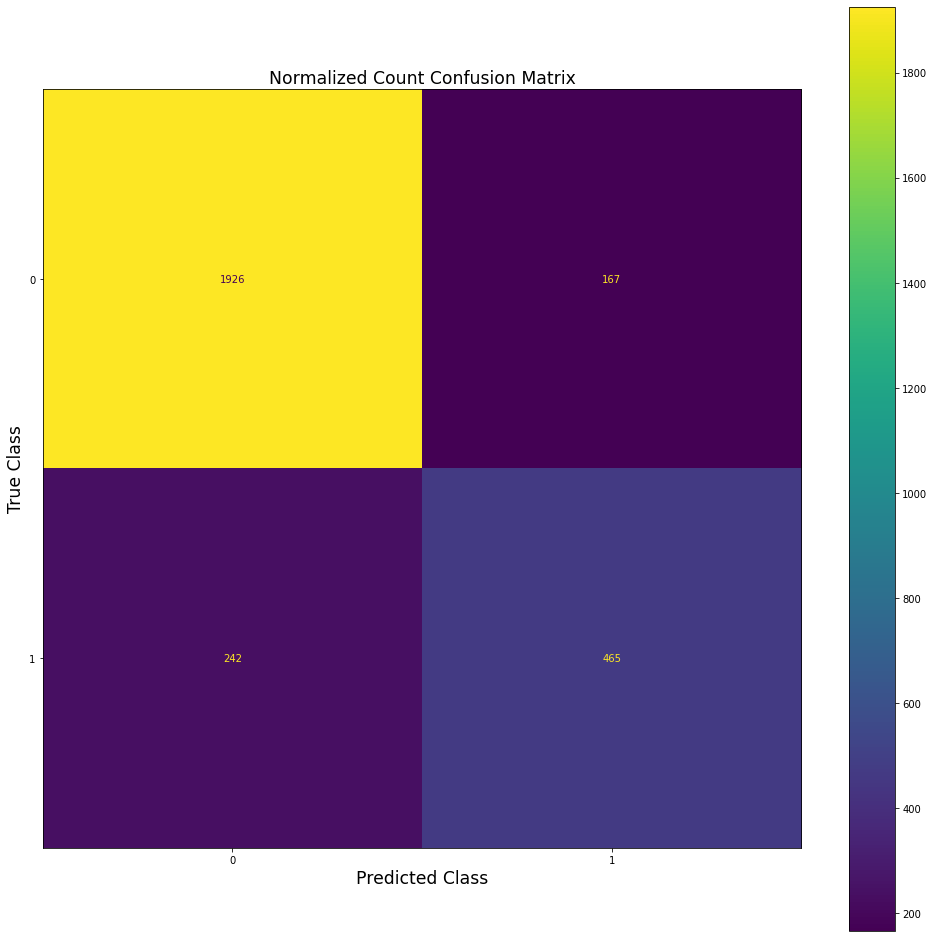

In [ ]:

# this will compute the matrix
cm = metrics.confusion_matrix(y_test, normalized_count_predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

# preparing for the plot
fig, ax = plt.subplots( figsize= (17, 17))

# displays data as an image
disp.plot(ax=ax)


plt.xlabel('Predicted Class', size='xx-large')
plt.ylabel('True Class', size='xx-large')
plt.title('Normalized Count Confusion Matrix', size='xx-large')
plt.show()

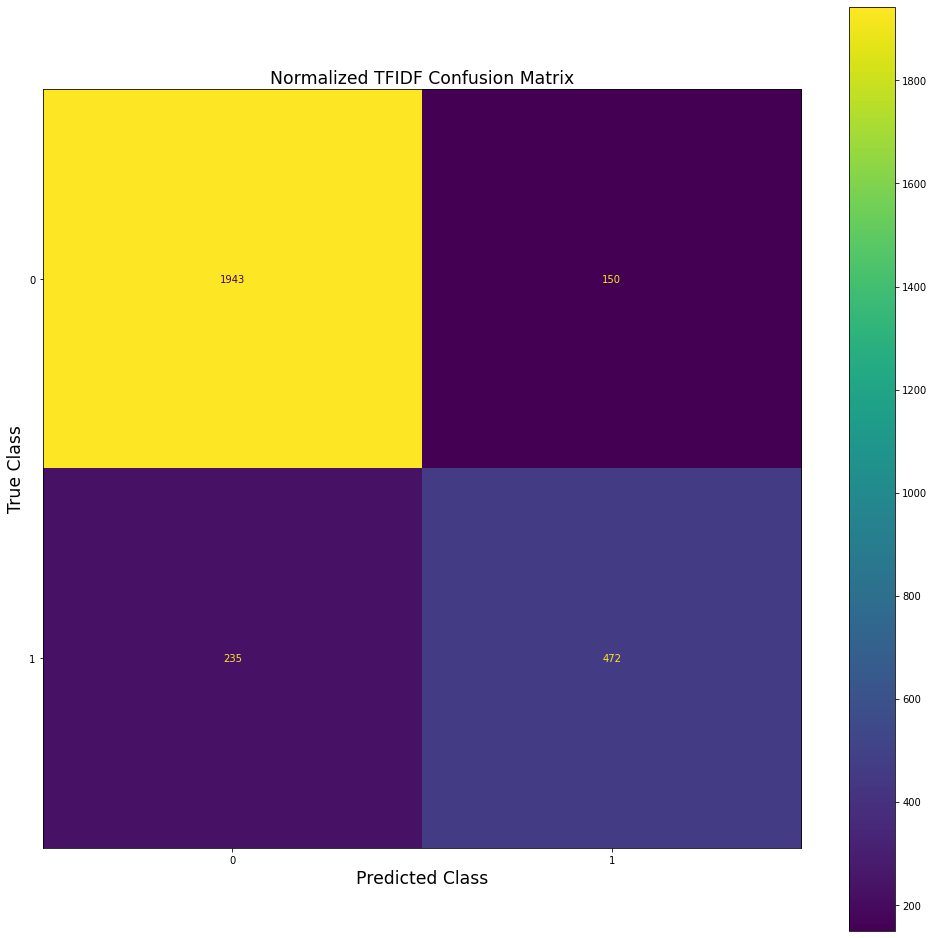

In [ ]:

# this will compute the matrix
cm = metrics.confusion_matrix(y_test, normalized_tfidf_predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

# preparing for the plot
fig, ax = plt.subplots( figsize= (17, 17))

# displays data as an image
disp.plot(ax=ax)


plt.xlabel('Predicted Class', size='xx-large')
plt.ylabel('True Class', size='xx-large')
plt.title('Normalized TFIDF Confusion Matrix', size='xx-large')
plt.show()

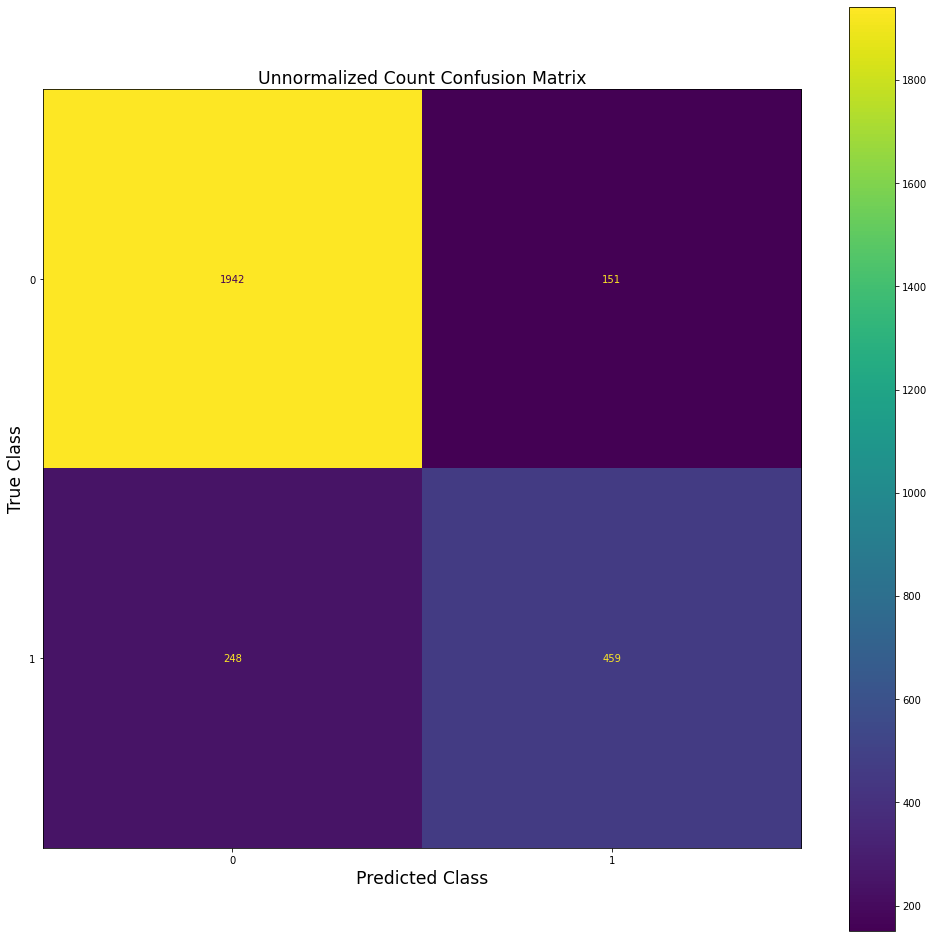

In [ ]:

# this will compute the matrix
cm = metrics.confusion_matrix(y_test, unnormalized_count_predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

# preparing for the plot
fig, ax = plt.subplots( figsize= (17, 17))

# displays data as an image
disp.plot(ax=ax)


plt.xlabel('Predicted Class', size='xx-large')
plt.ylabel('True Class', size='xx-large')
plt.title('Unnormalized Count Confusion Matrix', size='xx-large')
plt.show()

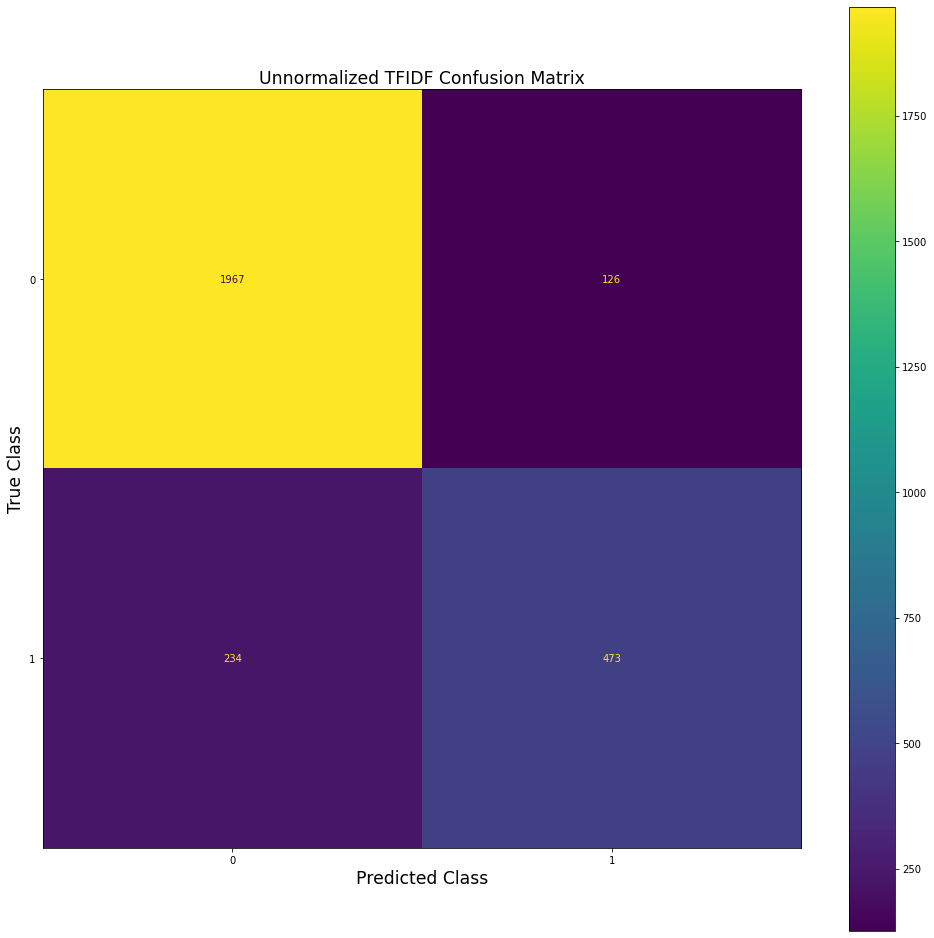

In [ ]:

# this will compute the matrix
cm = metrics.confusion_matrix(y_test, unnormalized_tfidf_predictions)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)

# preparing for the plot
fig, ax = plt.subplots( figsize= (17, 17))

# displays data as an image
disp.plot(ax=ax)


plt.xlabel('Predicted Class', size='xx-large')
plt.ylabel('True Class', size='xx-large')
plt.title('Unnormalized TFIDF Confusion Matrix', size='xx-large')
plt.show()